# Example of tilted states for the asymmetry modes section

In [1]:
import numpy as np
from functools import reduce

from scipy.special import comb
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

import functions as fn
import helpers as hl

ls_styles = hl.ls_styles

# colors for custom colormap
_colors = ["#9b4b2a", "#ff7f31", "#fce3a4"]
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", _colors, N=256)
norm = plt.Normalize(vmin=0, vmax=np.pi)
smJ = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)

In [2]:
def initial_state(N, qkeep, theta):
    """
    Create the initial state as (exp(-i theta/2 sigma_y) |0>)^⊗N
    """
    Ns = len(qkeep)
    Ne = N - Ns

    state_s = reduce(
        np.kron,
        [fn.r_y(theta) @ np.array([1, 0j])] * Ns
    )
    rho_s = np.outer(state_s, state_s.conj())

    rho_e = np.eye(2**Ne, dtype=complex)
    rho_e /= np.trace(rho_e)

    return np.kron(rho_e, rho_s)

In [3]:
# Example parameters
N = 4
Ns = 3
Ne = N - Ns
qkeep = range(Ne, N)

sectors_s = np.array([
    int(comb(Ns, int(Ns / 2 + m)))
    for m in np.arange(-Ns / 2, Ns / 2 + 1)
])

# Build projectors and unitaries
projectors_se, U_U1_se = fn.build_projectors(N)
projectors_s, U_U1_s = fn.build_projectors(Ns)

if Ne != 1:
    projectors_e, U_U1_e = fn.build_projectors(Ne)
else:
    projectors_e = {-.5: np.array([1, 0]), .5: np.array([0, 1])}
    U_U1_e = np.eye(Ne)

# Prepare example states
states = [
    initial_state(N, qkeep, theta)
    for theta in [0, np.pi / 4, np.pi / 2]
]
states = [fn.ptrace(state, qkeep) for state in states]

# Reference norms for normalization
modes = fn.asymmetry_modes(states[-1], sectors_s)
norms_norm = np.array([fn.compute_norm(modes[i]) for i in range(len(modes))])

norms_list = []
# Plot each example
for idx in range(Ns):
    # Compute and plot asymmetry norms as bars
    rho_s = states[idx]
    modes = fn.asymmetry_modes(rho_s, sectors_s)
    norms = np.array([fn.compute_norm(modes[i]) for i in range(len(modes))])
    norms /= norms_norm

    norms_list.append(norms)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


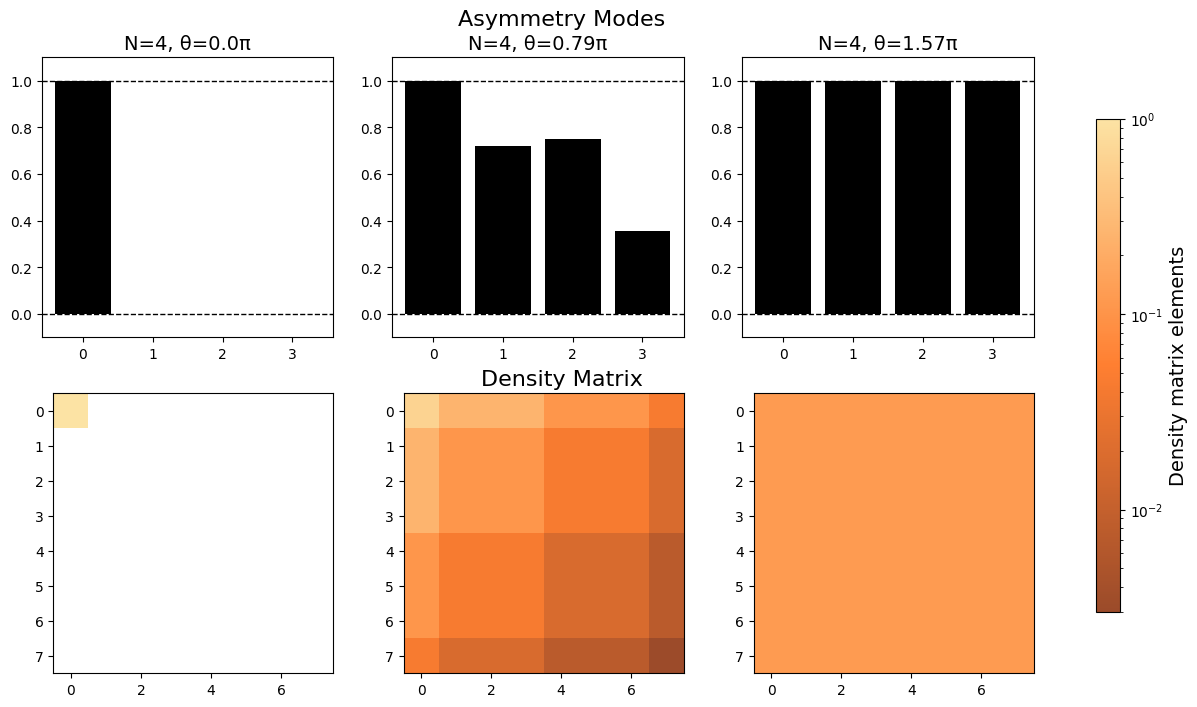

In [15]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(16, 8))


# Add row titles
fig.text(0.45, 0.92, 'Asymmetry Modes', ha='center', fontsize=16)
fig.text(0.45, 0.47, 'Density Matrix', ha='center', fontsize=16)
# Plot each example
for idx in range(Ns):
    ax_top = axs[0, idx]
    ax_bot = axs[1, idx]

    # Horizontal guides
    ax_top.axhline(0, color='black', lw=1, ls='--')
    ax_top.axhline(1, color='black', lw=1, ls='--')
    
    norms = norms_list[idx]

    x = np.arange(len(norms))
    ax_top.bar(x, norms,
               color='black',
               label='Asymmetry norms')
    ax_top.set_ylim(-0.1, 1.1)
    ax_top.set_xticks(x)

    cmap1.set_bad(color='white')

    d1 = np.ma.masked_less(
        np.abs(U_U1_s.conj().T @ states[idx] @ U_U1_s),
        1e-12
    )

    im = ax_bot.imshow(
        d1,
        cmap=cmap1,
        norm=LogNorm(0.003, 1.0),
        interpolation='none'
    )
    axs[0,idx].set_title(f'N={N}, θ={np.round(np.pi/2 * idx / (Ns-1), 2)}π', fontsize=14)

# Shared colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
cbar.set_label('Density matrix elements', fontsize=14)